In [29]:
import numpy as np
import astropy.units as u
from astropy.constants import G
import astropy.table as tbl
from ReadFile import Read 
from CenterOfMass import CenterOfMass
import matplotlib.pyplot as plt

In [30]:
class MassProfile():
    "calculate mass profiles and rotation curves of given galaxy at snapshot"
    def __init__(self,galaxy,snap):
        "initialize class, takes galaxy as string, snap as integer"
        "store galaxy"
        self.gname = galaxy
        "constructs filename"
        ilbl = '000' + str(snap)
        ilbl = ilbl[-3:]
        self.filename = f"{galaxy}_{ilbl}.txt"
        "read in the data"
        self.time, self.total, self.data = Read(self.filename)

        "stores positions and mass"
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
        self.m = self.data['m'] * 1e10 * u.Msun
        #compute com using disk particle data
        com_object = CenterOfMass(self.filename, 2)
        self.com_pos = com_object.COM_P(0.1) #tolerance

        "change units of G constant"
        self.G = G.to(u.kpc * u.km**2 / (u.s**2 * u.Msun))

    def MassEnclosed(self,ptype,radii):
        
        "compute the mass enclosed within a given radius of the COM position for a specified galaxy and a specified component of that galaxy"
        "takes in ptype and radii"
        "returns enclosed mass"

        "initialize array"
        index = np.where(self.data['type'] == ptype)
        "select particles for given type"
        m_selected = self.m[index]
        x_selected = self.x[index]
        y_selected = self.y[index]
        z_selected = self.z[index]

        #center relative to COM
        dx = x_selected - self.com_pos[0]
        dy = y_selected - self.com_pos[1]
        dz = z_selected - self.com_pos[2]
        r_part = np.sqrt(dx**2 + dy**2 + dz**2)

        radii_kpc = radii * u.kpc #convert units

        enclosed_mass = np.zeros(len(radii_kpc)) * u.Msun #initialize array

        for i in range(len(radii_kpc)): #loop over radii
            index_with = np.where(r_part < radii_kpc[i])
            enclosed_mass[i] = np.sum(m_selected[index_with])

        return enclosed_mass

    def MassEnclosedTotal(self,radii):
        #computed total enclosed mass of halo, disk, and bulge
        #inputs radii and outputs mass array at each radius within radii

        #halo and disk
        m_halo = self.MassEnclosed(1, radii)
        m_disk = self.MassEnclosed(2, radii)
        #take into account for M33 not having a bulge
        if self.gname == 'M33':
            m_bulge = 0 * m_halo

        else:
            m_bulge = self.MassEnclosed(3, radii)
        
        total_mass = m_halo + m_disk + m_bulge #calculate total mass
        return total_mass

    def HernquistMass(self, r, a, Mhalo):
        #compute enclosed mass within certain radii
        #inputs radius, scale radius, mhalo, returns enclosed mass at radius r in Msun

        #change units
        r_kpc = r * u.kpc
        a_kpc = a * u.kpc
        Mhalo_sun = Mhalo * u.Msun

        frac = (r_kpc**2) / ((r_kpc + a_kpc)**2)
        M_hernq = Mhalo_sun * frac
        return M_hernq

    def CircularVelocity(self, ptype, radii):
        #takes inputs of particle type and certain radii and then calculate velocity
        #outputs arrary of circular speeds
        Massenc = self.MassEnclosed(ptype, radii) #stores enclosed mass and changes radius to kpc
        r_kpc = radii * u.kpc
        #calculate circular velocity and round
        Vcirc = np.sqrt(self.G * Massenc / r_kpc)
        Vcirc = np.round(Vcirc, 2)
        return Vcirc

    def CircularVelocityTotal(self, radii):
        #takes inputs of given radius and outputs total circular velocity
        M_tot = self.MassEnclosedTotal(radii)  # Msun
        r_kpc = radii * u.kpc
        
        V_circ = np.sqrt(self.G * M_tot / r_kpc)
        return np.round(V_circ, 2)

    def HernquistVCirc(self, r, a, Mhalo):
        #take inputs of radius, scale radius, and mass of halo in a given galaxy
        #outputs circular veloicty

        r_kpc = r * u.kpc #change units
        a_kpc = a * u.kpc
        Mhalo_sun = Mhalo * u.Msun
        
        # M(r) for Hernquist
        M_hernq = Mhalo_sun * (r_kpc**2 / ((r_kpc + a_kpc)**2))
        
        V_hern = np.sqrt(self.G * M_hernq / r_kpc)
        V_hern = np.round(V_hern, 2)
        return V_hern

CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.47043363423848117
maxR 5.5102406666990555
CHANGE =  0.20089037674475652
maxR 2.7551203333495278
CHANGE =  0.030187165196947863
maxR 1.3775601666747639
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.01308865872044862
maxR 3.9330197268235163


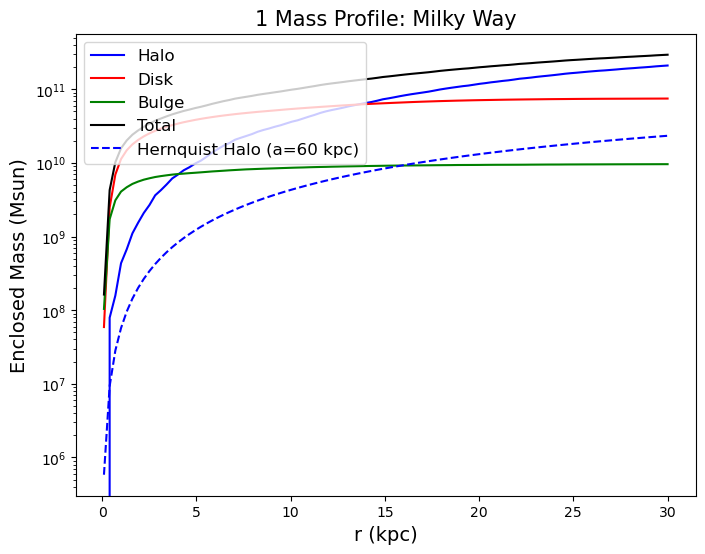

<Figure size 640x480 with 0 Axes>

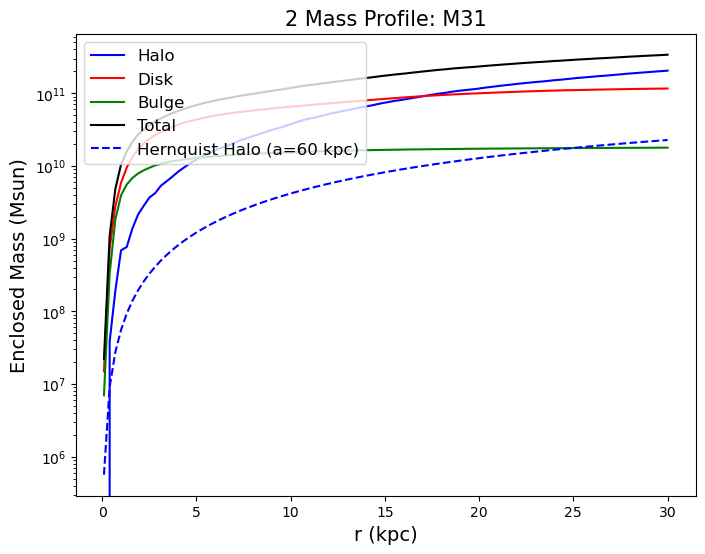

<Figure size 640x480 with 0 Axes>

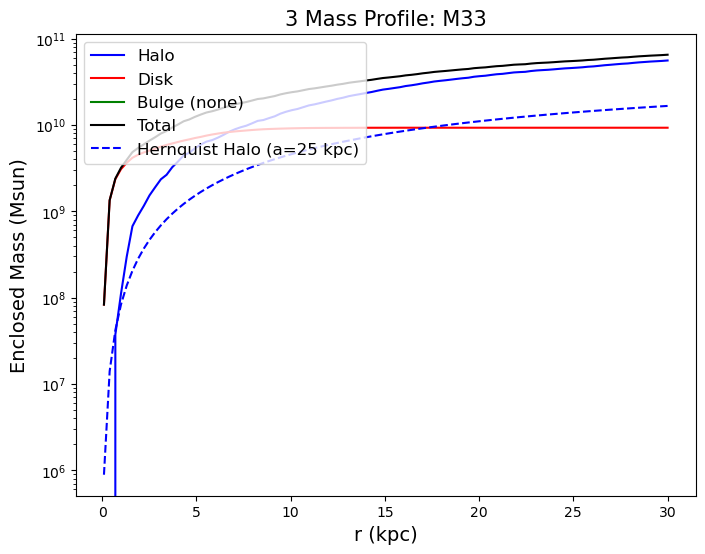

<Figure size 640x480 with 0 Axes>

In [31]:
# Create MassProfile objects for each galaxy at Snapshot 0
MW = MassProfile("MW", 0)
M31 = MassProfile("M31", 0)
M33 = MassProfile("M33", 0)

# Define an array of radii from 0.1 to 30 kpc
r = np.linspace(0.1, 30, 100)

##################################
# Milky Way Mass Profile
##################################
M_halo_MW = MW.MassEnclosed(1, r)
M_disk_MW = MW.MassEnclosed(2, r)
M_bulge_MW = MW.MassEnclosed(3, r)  # MW has a bulge
M_total_MW = MW.MassEnclosedTotal(r)

# We'll guess the total halo mass from the largest radius in M_halo:
MW_halo_mass = M_halo_MW[-1].value  # Msun, float
a_guess_MW = 60  # kpc, for example. Adjust as needed for best fit.

# Hernquist profile for the halo only
M_hern_MW = MW.HernquistMass(r, a_guess_MW, MW_halo_mass)

# Plot for MW
plt.figure(figsize=(8,6))
plt.semilogy(r, M_halo_MW, color='b', label='Halo')
plt.semilogy(r, M_disk_MW, color='r', label='Disk')
plt.semilogy(r, M_bulge_MW, color='g', label='Bulge')
plt.semilogy(r, M_total_MW, color='k', label='Total')

# Overplot Hernquist
plt.semilogy(r, M_hern_MW, 'b--', label=f'Hernquist Halo (a={a_guess_MW} kpc)')

plt.title('1 Mass Profile: Milky Way', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()
plt.savefig("1 Mass Profile Milky Way.png", dpi=300, bbox_inches="tight")


##################################
# M31 Mass Profile

M_halo_M31 = M31.MassEnclosed(1, r)
M_disk_M31 = M31.MassEnclosed(2, r)
M_bulge_M31 = M31.MassEnclosed(3, r)  # M31 has a bulge
M_total_M31 = M31.MassEnclosedTotal(r)

# Get total M31 halo mass from the last point in M_halo
M31_halo_mass = M_halo_M31[-1].value
a_guess_M31 = 60  # Adjust as needed

M_hern_M31 = M31.HernquistMass(r, a_guess_M31, M31_halo_mass)

plt.figure(figsize=(8,6))
plt.semilogy(r, M_halo_M31, color='b', label='Halo')
plt.semilogy(r, M_disk_M31, color='r', label='Disk')
plt.semilogy(r, M_bulge_M31, color='g', label='Bulge')
plt.semilogy(r, M_total_M31, color='k', label='Total')

plt.semilogy(r, M_hern_M31, 'b--', label=f'Hernquist Halo (a={a_guess_M31} kpc)')

plt.title('2 Mass Profile: M31', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()
plt.savefig("2 Mass Profile M31.png", dpi=300, bbox_inches="tight")


##################################
# M33 Mass Profile
##################################
# M33 has no bulge, so bulge mass is automatically 0
M_halo_M33 = M33.MassEnclosed(1, r)
M_disk_M33 = M33.MassEnclosed(2, r)
M_bulge_M33 = 0.0 * M_halo_M33  # Just to keep consistent
M_total_M33 = M33.MassEnclosedTotal(r)

M33_halo_mass = M_halo_M33[-1].value
a_guess_M33 = 25  # Possibly smaller for M33's smaller halo

M_hern_M33 = M33.HernquistMass(r, a_guess_M33, M33_halo_mass)

plt.figure(figsize=(8,6))
plt.semilogy(r, M_halo_M33, color='b', label='Halo')
plt.semilogy(r, M_disk_M33, color='r', label='Disk')
plt.semilogy(r, M_bulge_M33, color='g', label='Bulge (none)')
plt.semilogy(r, M_total_M33, color='k', label='Total')

plt.semilogy(r, M_hern_M33, 'b--', label=f'Hernquist Halo (a={a_guess_M33} kpc)')

plt.title('3 Mass Profile: M33', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Enclosed Mass (Msun)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.show()
plt.savefig("3 Mass Profile M33.png", dpi=300, bbox_inches="tight")

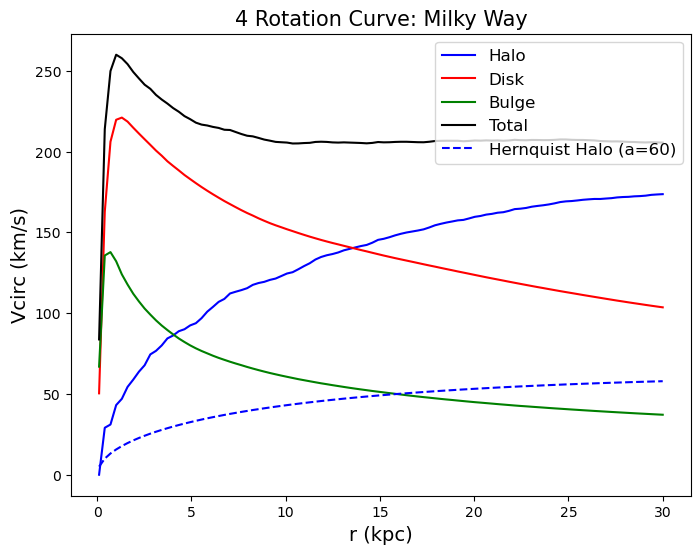

<Figure size 640x480 with 0 Axes>

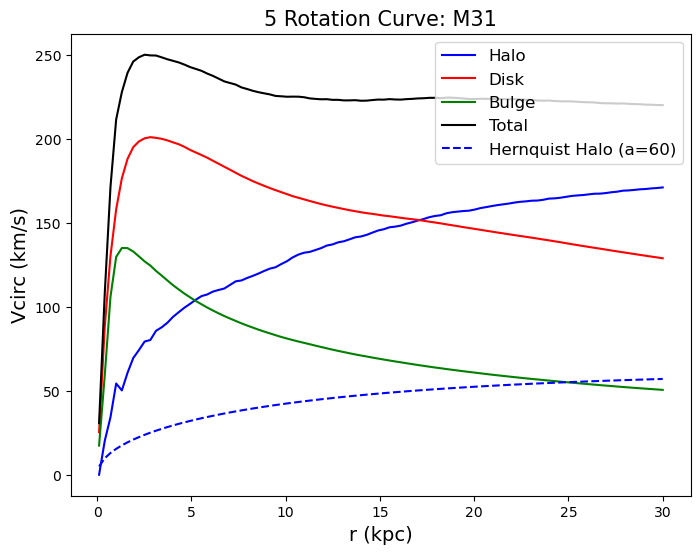

<Figure size 640x480 with 0 Axes>

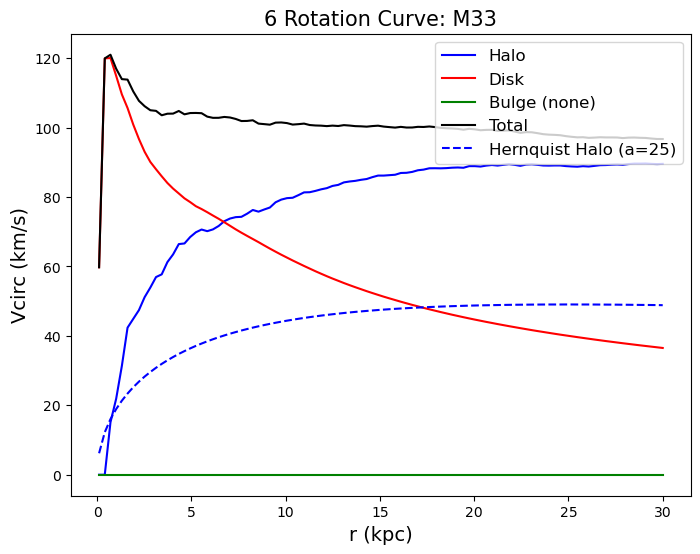

<Figure size 640x480 with 0 Axes>

In [32]:
# Define radii array for rotation curves (same or similar: 0.1 to 30 kpc)
r_circ = np.linspace(0.1, 30, 100)

##################################
# Milky Way Rotation Curve
##################################
Vhalo_MW = MW.CircularVelocity(1, r_circ)
Vdisk_MW = MW.CircularVelocity(2, r_circ)
Vbulge_MW = MW.CircularVelocity(3, r_circ)
Vtotal_MW = MW.CircularVelocityTotal(r_circ)

# We'll reuse the halo mass and scale radius guesses from above
VC_hern_MW = MW.HernquistVCirc(r_circ, a_guess_MW, MW_halo_mass)

plt.figure(figsize=(8,6))
plt.plot(r_circ, Vhalo_MW, 'b', label='Halo')
plt.plot(r_circ, Vdisk_MW, 'r', label='Disk')
plt.plot(r_circ, Vbulge_MW, 'g', label='Bulge')
plt.plot(r_circ, Vtotal_MW, 'k', label='Total')
plt.plot(r_circ, VC_hern_MW, 'b--', label=f'Hernquist Halo (a={a_guess_MW})')

plt.title('4 Rotation Curve: Milky Way', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Vcirc (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.show()
plt.savefig("4 Rotation Curve Milky Way.png", dpi=300, bbox_inches="tight")


##################################
# M31 Rotation Curve
##################################
Vhalo_M31 = M31.CircularVelocity(1, r_circ)
Vdisk_M31 = M31.CircularVelocity(2, r_circ)
Vbulge_M31 = M31.CircularVelocity(3, r_circ)
Vtotal_M31 = M31.CircularVelocityTotal(r_circ)

VC_hern_M31 = M31.HernquistVCirc(r_circ, a_guess_M31, M31_halo_mass)

plt.figure(figsize=(8,6))
plt.plot(r_circ, Vhalo_M31, 'b', label='Halo')
plt.plot(r_circ, Vdisk_M31, 'r', label='Disk')
plt.plot(r_circ, Vbulge_M31, 'g', label='Bulge')
plt.plot(r_circ, Vtotal_M31, 'k', label='Total')
plt.plot(r_circ, VC_hern_M31, 'b--', label=f'Hernquist Halo (a={a_guess_M31})')

plt.title('5 Rotation Curve: M31', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Vcirc (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.show()
plt.savefig("5 Rotation Curve M31.png", dpi=300, bbox_inches="tight")


##################################
# M33 Rotation Curve
##################################
Vhalo_M33 = M33.CircularVelocity(1, r_circ)
Vdisk_M33 = M33.CircularVelocity(2, r_circ)
# M33 has no bulge, so we skip or set to zero
Vbulge_M33 = 0.0 * Vhalo_M33
Vtotal_M33 = M33.CircularVelocityTotal(r_circ)

VC_hern_M33 = M33.HernquistVCirc(r_circ, a_guess_M33, M33_halo_mass)

plt.figure(figsize=(8,6))
plt.plot(r_circ, Vhalo_M33, 'b', label='Halo')
plt.plot(r_circ, Vdisk_M33, 'r', label='Disk')
plt.plot(r_circ, Vbulge_M33, 'g', label='Bulge (none)')
plt.plot(r_circ, Vtotal_M33, 'k', label='Total')
plt.plot(r_circ, VC_hern_M33, 'b--', label=f'Hernquist Halo (a={a_guess_M33})')

plt.title('6 Rotation Curve: M33', fontsize=15)
plt.xlabel('r (kpc)', fontsize=14)
plt.ylabel('Vcirc (km/s)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.show()
plt.savefig("6 Rotation Curve M33.png", dpi=300, bbox_inches="tight")